In [1]:
# CREDITS - https://idiotdeveloper.com/unet-segmentation-with-pretrained-mobilenetv2-as-encoder/
import os
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.python.keras.metrics import Recall, Precision
from tensorflow.python.keras.optimizer_v2.nadam import Nadam
from models.losses.dice import dice_coefficient, dice_loss
import numpy as np

from utils.Dataset import MIRDCRicord1aDataset, array_to_rgb, read_image, read_mask
from models.UMobileNetV2 import build_model

In [2]:
dataset_path = os.path.abspath(os.path.join(os.pardir, 'data'))
dataset = MIRDCRicord1aDataset('\\\\?\\' + dataset_path)

In [3]:
IMAGE_SIZE = dataset.IMAGE_SIZE
EPOCHS = 30
BATCH = 8
LR = 1e-4

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = dataset.load_data()

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  8
Validation data:  6
Testing data:  6


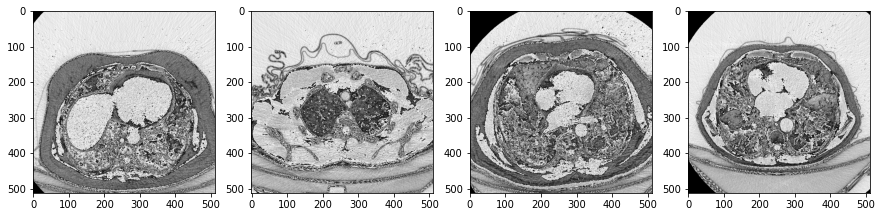

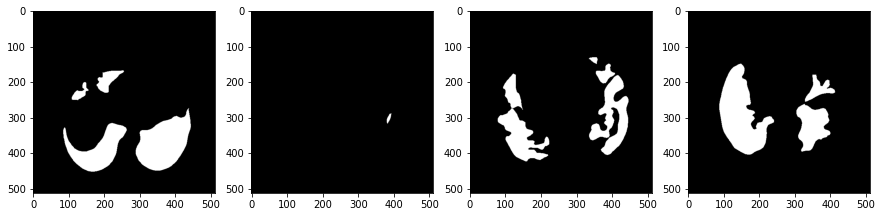

In [4]:
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 4, 1)
plt.imshow(array_to_rgb(train_x[0]))
fig.add_subplot(1, 4, 2)
plt.imshow(array_to_rgb(train_x[1]))
fig.add_subplot(1, 4, 3)
plt.imshow(array_to_rgb(train_x[2]))
fig.add_subplot(1, 4, 4)
plt.imshow(array_to_rgb(train_x[3]))

fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 4, 1)
plt.imshow(array_to_rgb(train_y[0]))
fig.add_subplot(1, 4, 2)
plt.imshow(array_to_rgb(train_y[1]))
fig.add_subplot(1, 4, 3)
plt.imshow(array_to_rgb(train_y[2]))
fig.add_subplot(1, 4, 4)
plt.imshow(array_to_rgb(train_y[3]))

In [5]:
train_dataset = dataset.tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = dataset.tf_dataset(valid_x, valid_y, batch=BATCH)

In [6]:
opt = Nadam(LR)
metrics = [dice_coefficient, Recall(), Precision()]
model = build_model((IMAGE_SIZE, IMAGE_SIZE, 3), metrics, dice_loss, opt)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 16)   432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 16)   64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 16)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [7]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [8]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
1/1 [==============================] - 17s 17s/step - loss: 0.9014 - dice_coefficient: 0.0986 - recall: 0.1451 - precision: 0.0806 - val_loss: 0.9269 - val_dice_coefficient: 0.0731 - val_recall: 0.2147 - val_precision: 0.0433
Epoch 2/30
1/1 [==============================] - 1s 948ms/step - loss: 0.8935 - dice_coefficient: 0.1065 - recall: 0.1825 - precision: 0.0961 - val_loss: 0.9265 - val_dice_coefficient: 0.0735 - val_recall: 0.2458 - val_precision: 0.0440
Epoch 3/30
1/1 [==============================] - 1s 1s/step - loss: 0.8878 - dice_coefficient: 0.1122 - recall: 0.2155 - precision: 0.1092 - val_loss: 0.9260 - val_dice_coefficient: 0.0740 - val_recall: 0.2788 - val_precision: 0.0448
Epoch 4/30
1/1 [==============================] - 1s 965ms/step - loss: 0.8823 - dice_coefficient: 0.1177 - recall: 0.2517 - precision: 0.1229 - val_loss: 0.9255 - val_dice_coefficient: 0.0745 - val_recall: 0.3164 - val_precision: 0.0461
Epoch 5/30
1/1 [==============================] - 1s

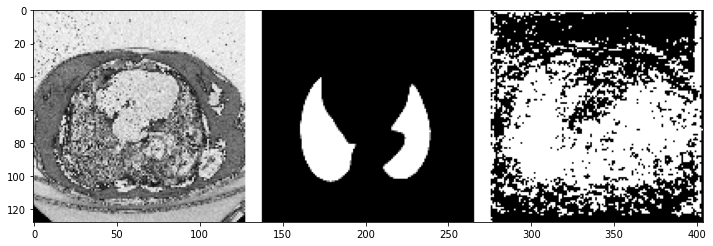

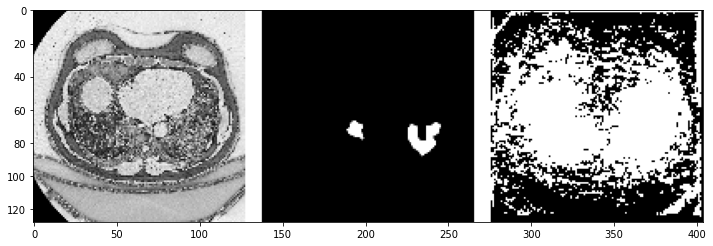

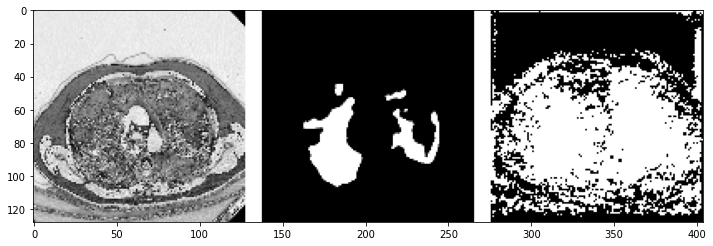

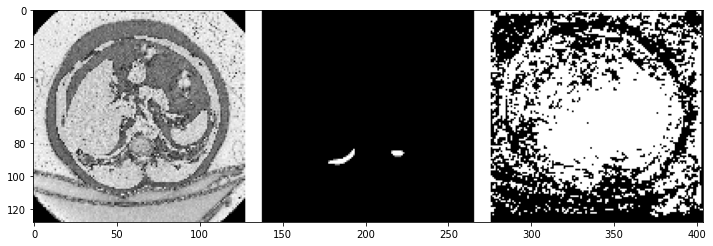

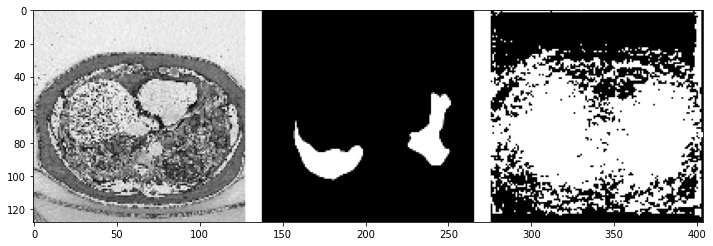

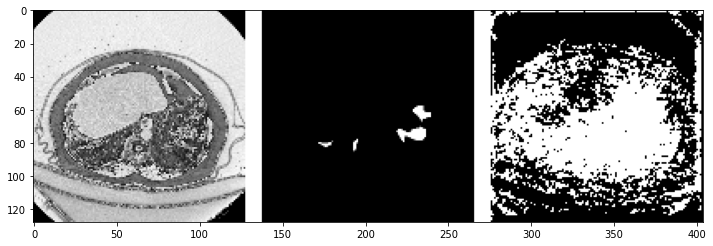

In [9]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x, IMAGE_SIZE)
    y = read_mask(y, IMAGE_SIZE)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    img_plot = plt.imshow(image)
